# IIC-2433 Minería de Datos UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- sklearn 1.0.2
- matplotlib 3.5.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

dataset = datasets.make_moons(n_samples=1000, noise=0.1) 
X, y = dataset

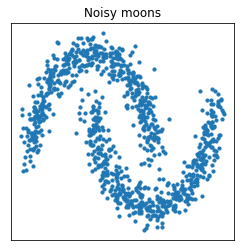

In [2]:
plt.figure(figsize=(4, 4))
plt.title("Noisy moons")
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.xticks(())
plt.yticks(())
plt.show()


## Actividad en clase

Clusterice el dataset usando **DBSCAN** y **OPTICS**. Para esto haga lo siguiente:

- Calcule un kdist plot para k=5. Usando el gráfico, escoja EPS. 
- Corra **DBSCAN** con estos parámetros y grafique el dataset según los clusters encontrados. 
- Corra **OPTICS** con estos parámetros y un min_cluster_size = 0.3. Grafique el dataset según los clusters encontrados.
- ¿Cuál de los dos algoritmos funcionó mejor? ¿Por qué?
- Cuanto termine, me avisa para entregarle una **L (logrado)**.
- Recuerde que las L otorgan un bono en la nota final de la asignatura.
- Pueden trabajar de a dos.

***Tiene hasta el final de la clase.***


# Solución

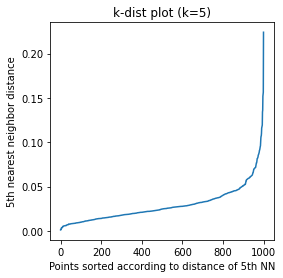

In [3]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(4, 4))
plt.xlabel("Points sorted according to distance of 5th NN")
plt.ylabel("5th nearest neighbor distance")
plt.title("k-dist plot (k=5)")
plt.plot(distances)
plt.show()

In [4]:
from sklearn import cluster

dbscan = cluster.DBSCAN(eps=0.1, min_samples=6)
model = dbscan.fit(X)

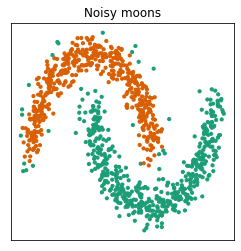

In [5]:
y_pred = model.labels_.astype(int)

def colour(x):
    return plt.cm.Dark2(x)

colors = list(map(colour,y_pred))

plt.figure(figsize=(4, 4))
plt.title("Noisy moons")
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors)
plt.xticks(())
plt.yticks(())
plt.show()

In [6]:
optics = cluster.OPTICS(min_samples=6, min_cluster_size=0.3)
optics = optics.fit(X)

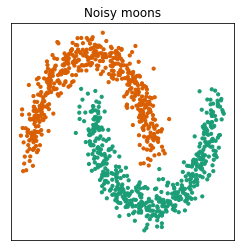

In [7]:
y_pred = optics.labels_.astype(int)

colors = list(map(colour,y_pred))

plt.figure(figsize=(4, 4))
plt.title("Noisy moons")
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors)
plt.xticks(())
plt.yticks(())
plt.show()

OPTICS funciona mejor ya que maneja mejor los noise points.